Install libraries

In [62]:
pip install pandas seaborn matplotlib scikit-learn numpy

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: /Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [63]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np

In [50]:
# Load the datasets
consolidated_data = pd.read_csv('./data/normalized/consolidatedNData.csv')
simplified_consolidated_data = pd.read_csv('./data/normalized/consolidatedNDataSimplified.csv')
returns_data = pd.read_csv('./data/normalized/treatedNReturns.csv')

Step 1: Clustering with K-Means
We'll use the consolidated_data DataFrame for clustering based on demographics and homelessness counts. The goal is to identify distinct groups within the data that might represent different risk profiles.

In [55]:
# Let's start by re-confirming the data types for the columns intended for calculation
print(simplified_consolidated_data.dtypes)

Unnamed: 0                           int64
CALENDAR_YEAR                        int64
AGE_GROUP_PUBLIC                    object
EXPERIENCING_HOMELESSNESS_CNT_x    float64
GENDER                              object
EXPERIENCING_HOMELESSNESS_CNT_y    float64
RACE                                object
RACE ALONE OR IN COMBINATION        object
EXPERIENCING_HOMELESSNESS_CNT      float64
Children_Flag                        int64
Adult_Flag                           int64
Elder_Flag                           int64
dtype: object


In [54]:
for col in ['EXPERIENCING_HOMELESSNESS_CNT_x', 'EXPERIENCING_HOMELESSNESS_CNT_y', 'EXPERIENCING_HOMELESSNESS_CNT']:
    simplified_consolidated_data[col] = pd.to_numeric(simplified_consolidated_data[col], errors='coerce')
for col in ['Rate', 'Rate_Change']:
    returns_data[col] = pd.to_numeric(returns_data[col], errors='coerce')

# consolidated_data.fillna(0, inplace=True)  # Example: fill NaNs with 0
# returns_data.fillna(0, inplace=True)

In [36]:
# Selecting relevant features for clustering
features_for_clustering = ['EXPERIENCING_HOMELESSNESS_CNT_x', 'EXPERIENCING_HOMELESSNESS_CNT_y', 'Children_Flag', 'Adult_Flag', 'Elder_Flag']
data_for_clustering = consolidated_data[features_for_clustering]

# Scaling the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data_for_clustering)

# Applying K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
consolidated_data['Cluster'] = kmeans.fit_predict(scaled_features)

# Viewing the first few entries to verify clustering results
print(consolidated_data.head())


   Unnamed: 0  CALENDAR_YEAR LOCATION_ID_x            LOCATION  \
0           0           2017        CA-502  ALAMEDA COUNTY COC   
1           1           2017        CA-502  ALAMEDA COUNTY COC   
2           2           2017        CA-502  ALAMEDA COUNTY COC   
3           3           2017        CA-502  ALAMEDA COUNTY COC   
4           4           2017        CA-502  ALAMEDA COUNTY COC   

  AGE_GROUP_PUBLIC  EXPERIENCING_HOMELESSNESS_CNT_x LOCATION_ID_y  \
0            18-24                          0.01195        CA-502   
1            18-24                          0.01195        CA-502   
2            18-24                          0.01195        CA-502   
3            18-24                          0.01195        CA-502   
4            18-24                          0.01195        CA-502   

          GENDER  EXPERIENCING_HOMELESSNESS_CNT_y LOCATION_ID  \
0  Cisgender Man                         0.020489      CA-502   
1  Cisgender Man                         0.020489      CA-

In [37]:
# Grouping by 'CALENDAR_YEAR', 'LOCATION', and 'Cluster', then aggregating
grouped_summary = consolidated_data.groupby(['CALENDAR_YEAR', 'LOCATION', 'Cluster']).agg({
    'EXPERIENCING_HOMELESSNESS_CNT_x': 'mean',
    'EXPERIENCING_HOMELESSNESS_CNT_y': 'mean',
    'EXPERIENCING_HOMELESSNESS_CNT': 'mean',
    'Children_Flag': 'mean',
    'Adult_Flag': 'mean',
    'Elder_Flag': 'mean'
}).reset_index()

print(grouped_summary.head())

   CALENDAR_YEAR                                           LOCATION  Cluster  \
0           2017                                 ALAMEDA COUNTY COC        0   
1           2017                                 ALAMEDA COUNTY COC        1   
2           2017                                 ALAMEDA COUNTY COC        2   
3           2017  AMADOR, CALAVERAS, MARIPOSA, TUOLUMNE COUNTIES...        0   
4           2017  AMADOR, CALAVERAS, MARIPOSA, TUOLUMNE COUNTIES...        1   

   EXPERIENCING_HOMELESSNESS_CNT_x  EXPERIENCING_HOMELESSNESS_CNT_y  \
0                         0.011248                         0.006330   
1                         0.028935                         0.006330   
2                         0.004201                         0.006330   
3                         0.000672                         0.001465   
4                         0.002654                         0.001465   

   EXPERIENCING_HOMELESSNESS_CNT  Children_Flag  Adult_Flag  Elder_Flag  
0                 

In [38]:
numeric_cols = ['EXPERIENCING_HOMELESSNESS_CNT_x', 'EXPERIENCING_HOMELESSNESS_CNT_y', 'EXPERIENCING_HOMELESSNESS_CNT', 'Children_Flag', 'Adult_Flag', 'Elder_Flag']

for col in numeric_cols:
    consolidated_data[col] = pd.to_numeric(consolidated_data[col], errors='raise')

# Perform groupby aggregation on verified numeric columns only
grouped_data = consolidated_data.groupby(['CALENDAR_YEAR', 'LOCATION', 'Cluster'], as_index=False)[numeric_cols].mean()


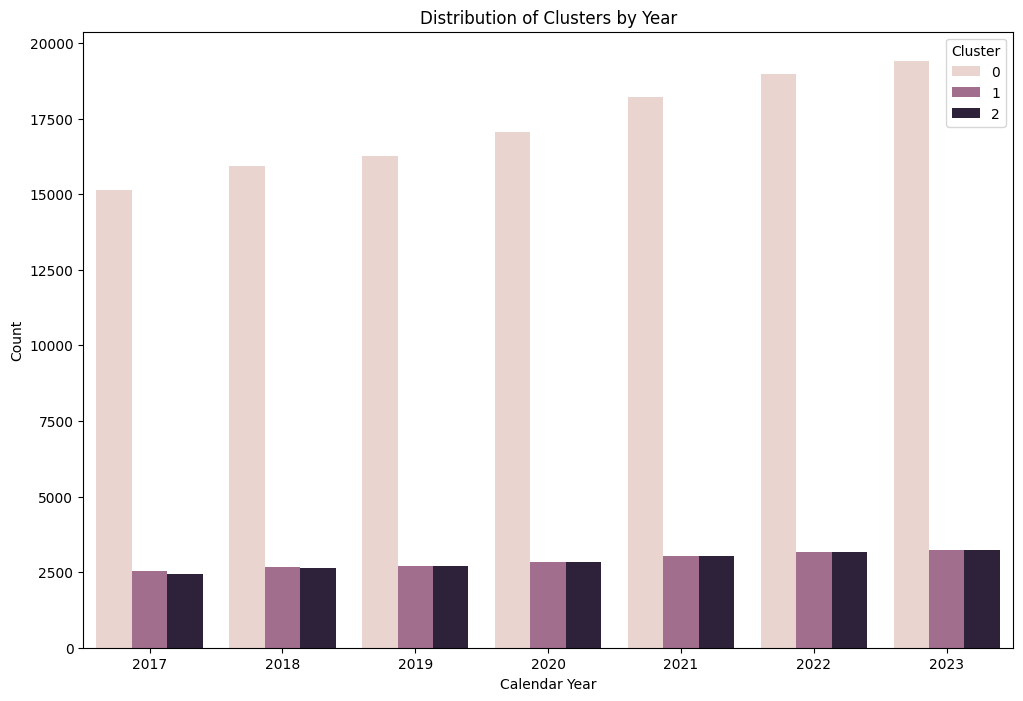

In [16]:
plt.figure(figsize=(12, 8))
sns.countplot(x='CALENDAR_YEAR', hue='Cluster', data=consolidated_data)
plt.title('Distribution of Clusters by Year')
plt.ylabel('Count')
plt.xlabel('Calendar Year')
plt.legend(title='Cluster')
plt.show()

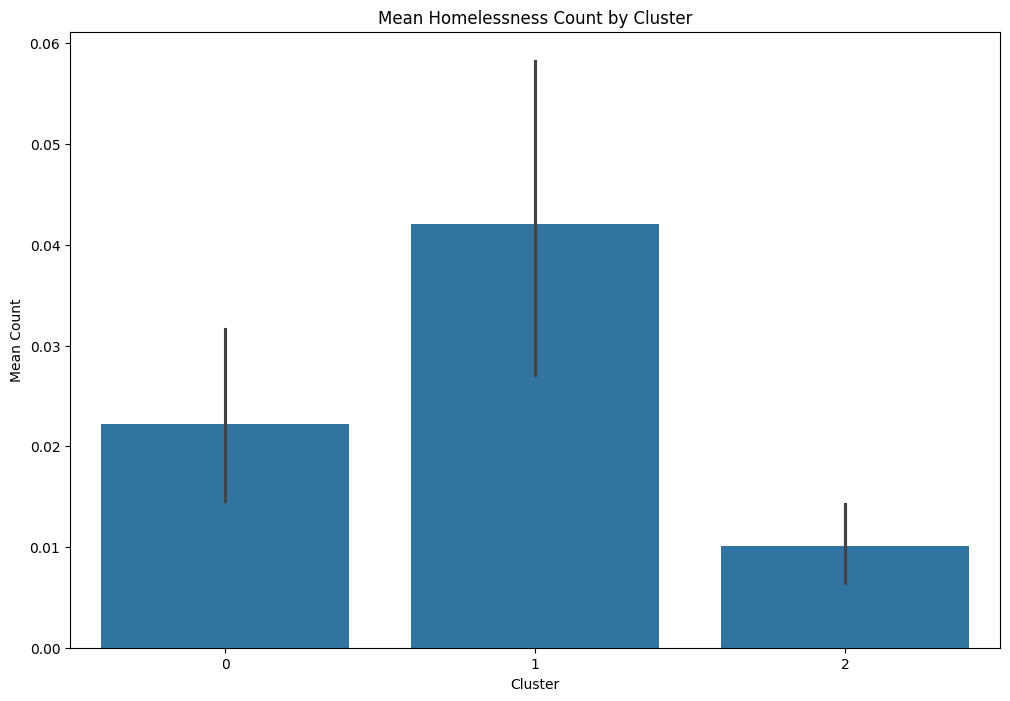

In [17]:
# Assuming 'grouped_summary' contains your aggregated data
# Visualizing mean homelessness counts for each cluster
plt.figure(figsize=(12, 8))
sns.barplot(x='Cluster', y='EXPERIENCING_HOMELESSNESS_CNT_x', data=grouped_summary)
plt.title('Mean Homelessness Count by Cluster')
plt.ylabel('Mean Count')
plt.xlabel('Cluster')
plt.show()

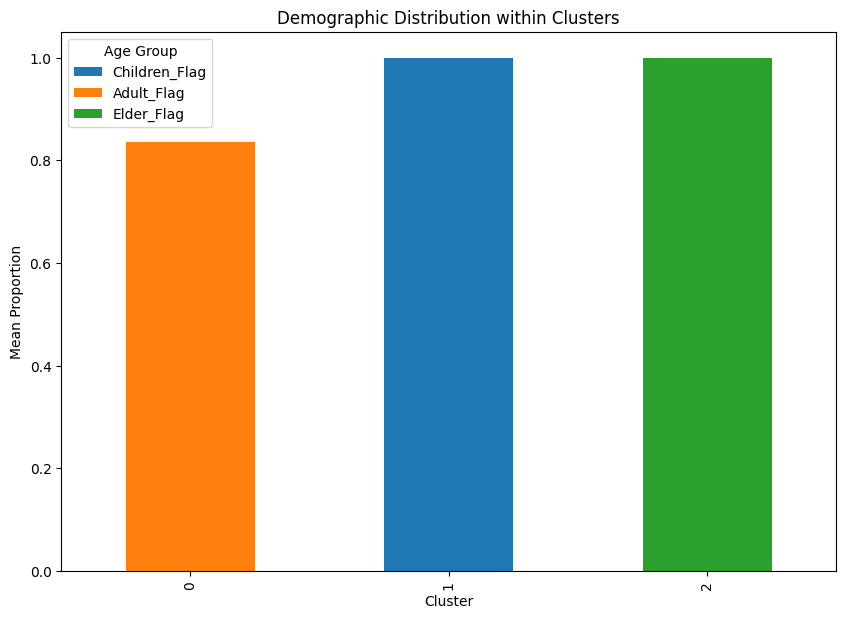

In [19]:
# First, calculate the mean proportion of each flag within each cluster
demographic_means = grouped_summary.groupby('Cluster')[['Children_Flag', 'Adult_Flag', 'Elder_Flag']].mean().reset_index()

# Then, plot these as a stacked bar chart
demographic_means.set_index('Cluster')[['Children_Flag', 'Adult_Flag', 'Elder_Flag']].plot(kind='bar', stacked=True, figsize=(10, 7))
plt.title('Demographic Distribution within Clusters')
plt.ylabel('Mean Proportion')
plt.xlabel('Cluster')
plt.legend(title='Age Group')
plt.show()

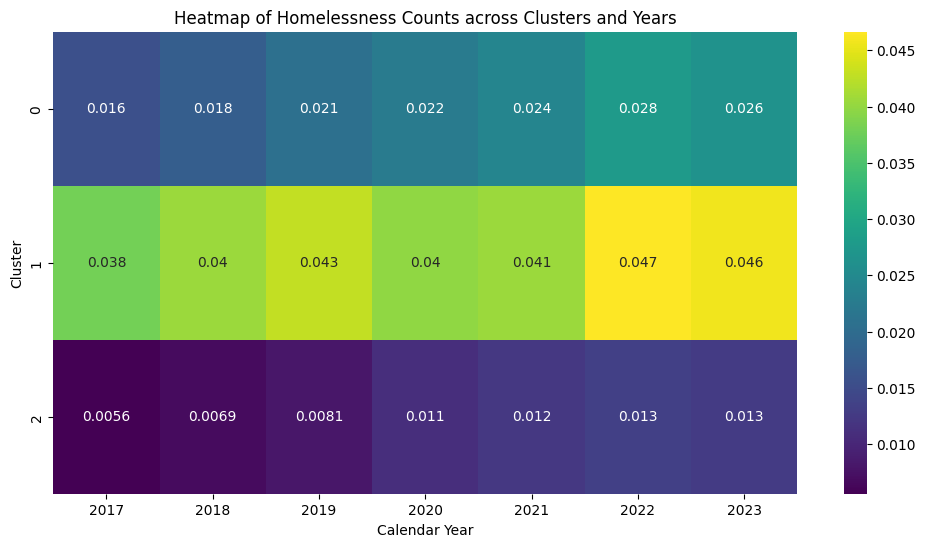

In [20]:
# Pivot table for heatmap
pivot_table = grouped_summary.pivot_table(index='Cluster', columns='CALENDAR_YEAR', values='EXPERIENCING_HOMELESSNESS_CNT_x')

# Plotting heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, annot=True, cmap='viridis')
plt.title('Heatmap of Homelessness Counts across Clusters and Years')
plt.ylabel('Cluster')
plt.xlabel('Calendar Year')
plt.show()

Profiling Clusters
The goal is to understand what each cluster represents by examining the average (mean) values of features within each cluster. This step helps in interpreting the clusters in the context of your data.

In [46]:
# Explicitly selecting numeric columns for mean calculation
numeric_columns = ['EXPERIENCING_HOMELESSNESS_CNT_x', 'EXPERIENCING_HOMELESSNESS_CNT_y', 'EXPERIENCING_HOMELESSNESS_CNT', 'Children_Flag', 'Adult_Flag', 'Elder_Flag']

# Calculating the mean for these columns within each cluster
cluster_profiles = consolidated_data.groupby('Cluster')[numeric_columns].mean()

# Display the calculated cluster profiles
print(cluster_profiles)


         EXPERIENCING_HOMELESSNESS_CNT_x  EXPERIENCING_HOMELESSNESS_CNT_y  \
Cluster                                                                     
0                               0.027799                         0.014307   
1                               0.051670                         0.014285   
2                               0.012577                         0.014372   

         EXPERIENCING_HOMELESSNESS_CNT  Children_Flag  Adult_Flag  Elder_Flag  
Cluster                                                                        
0                             0.019559            0.0    0.833545         0.0  
1                             0.019529            1.0    0.000000         0.0  
2                             0.019650            0.0    0.000000         1.0  


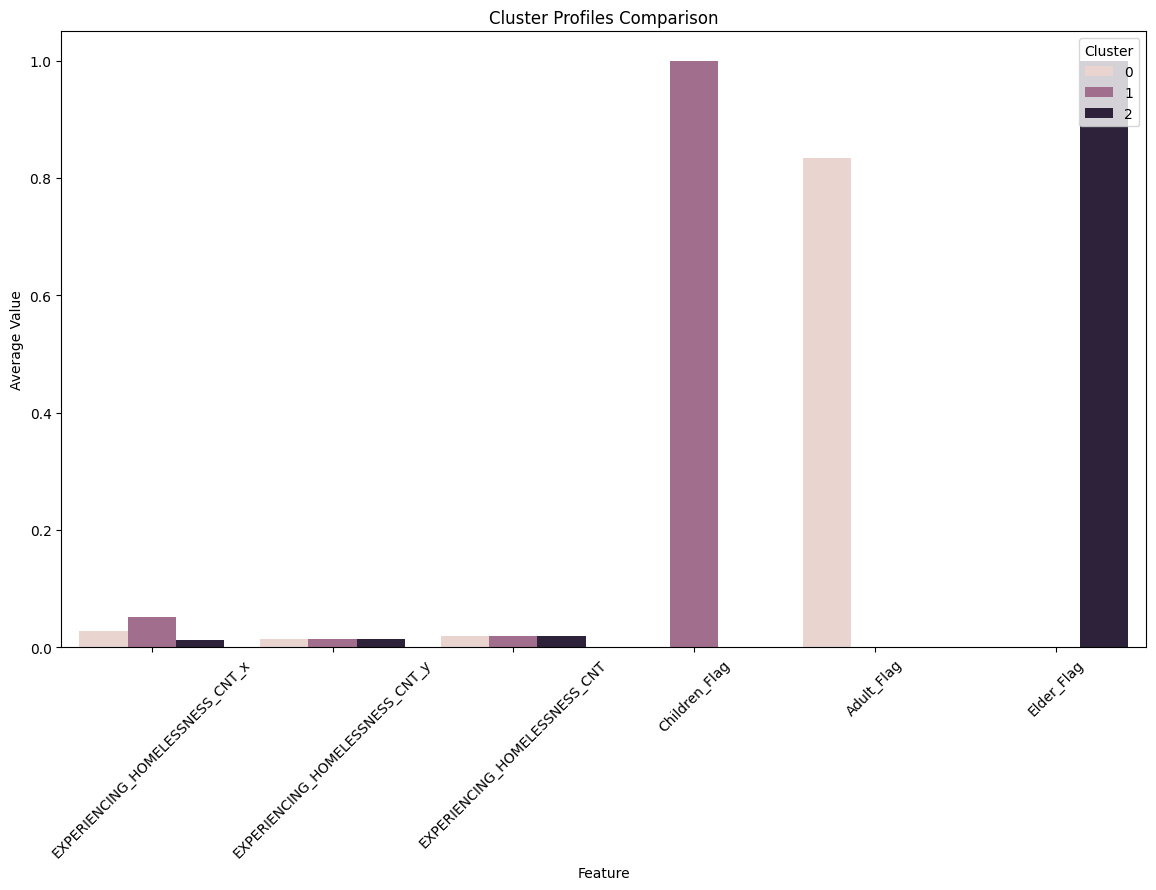

In [47]:
# Melting the DataFrame to make it suitable for sns.barplot
melted_cluster_profiles = cluster_profiles.reset_index().melt(id_vars=["Cluster"])

# Plotting
plt.figure(figsize=(14, 8))
sns.barplot(data=melted_cluster_profiles, x='variable', y='value', hue='Cluster')
plt.title('Cluster Profiles Comparison')
plt.xticks(rotation=45)
plt.ylabel('Average Value')
plt.xlabel('Feature')
plt.legend(title='Cluster', loc='upper right')
plt.show()

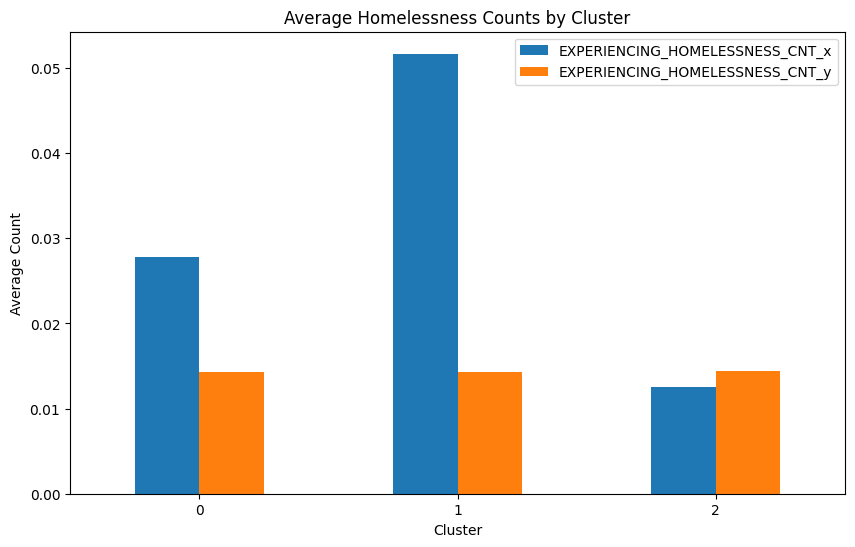

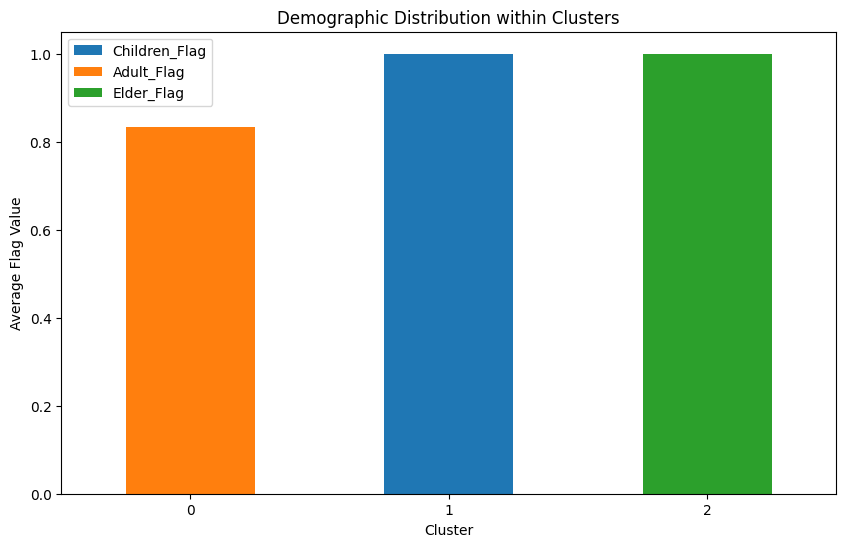

In [48]:
# Plotting average homelessness counts by cluster
cluster_profiles[['EXPERIENCING_HOMELESSNESS_CNT_x', 'EXPERIENCING_HOMELESSNESS_CNT_y']].plot(kind='bar', figsize=(10, 6))
plt.title('Average Homelessness Counts by Cluster')
plt.ylabel('Average Count')
plt.xlabel('Cluster')
plt.xticks(rotation=0)
plt.show()

# Plotting demographic distribution within clusters
cluster_profiles[['Children_Flag', 'Adult_Flag', 'Elder_Flag']].plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Demographic Distribution within Clusters')
plt.ylabel('Average Flag Value')
plt.xlabel('Cluster')
plt.xticks(rotation=0)
plt.show()


In [49]:
# Renaming clusters based on observed profiles
cluster_names = {0: 'Adult_Dominant', 1: 'Youth_Dominant', 2: 'Elder_Dominant'}
consolidated_data['Cluster_Name'] = consolidated_data['Cluster'].replace(cluster_names)

# Now, 'Cluster_Name' provides a more descriptive label of each cluster

Step 2: Correlation Analysis
Next, we'll perform a correlation analysis to see how different demographic proportions relate to the homelessness rate. This step assumes that we have calculated the proportions of different demographics (like what was suggested earlier) and now want to correlate these with the homelessness counts or rates.

In [ ]:
Feature Importance via Correlation Analysis
First, understanding how various demographics and calculated proportions correlate with homelessness counts can offer insights into what features are most predictive of homelessness.

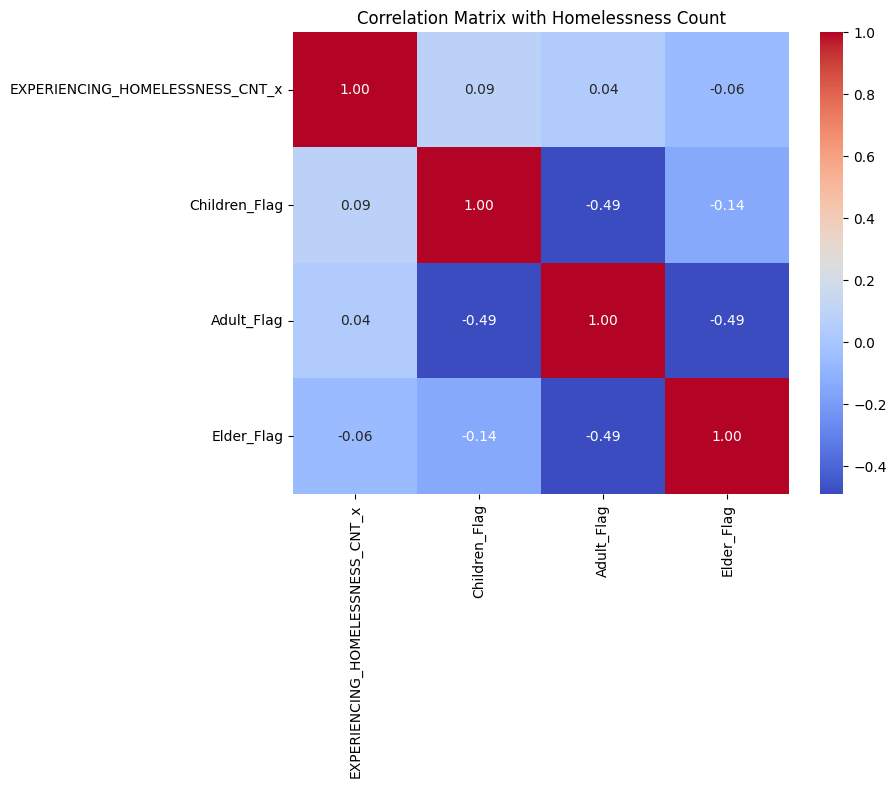

In [22]:
# Assuming 'consolidated_data' includes calculated proportions for gender, race, etc.
# Let's focus on numeric columns that represent counts or flags for now

# Calculating correlation matrix focused on homelessness counts and demographic flags
correlation_matrix = consolidated_data[['EXPERIENCING_HOMELESSNESS_CNT_x', 'Children_Flag', 'Adult_Flag', 'Elder_Flag']].corr()

# Visualizing the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix with Homelessness Count')
plt.show()


In [ ]:
This heatmap helps identify which demographic factors are most strongly correlated with the homelessness counts, indicating potential predictors for further analysis or modeling.

In [ ]:
Analyzing Mean Differences by Demographic Flags
To further understand the impact of specific demographic characteristics, analyze the mean homelessness counts by different demographic flags, comparing those flagged as children, adults, and elders.

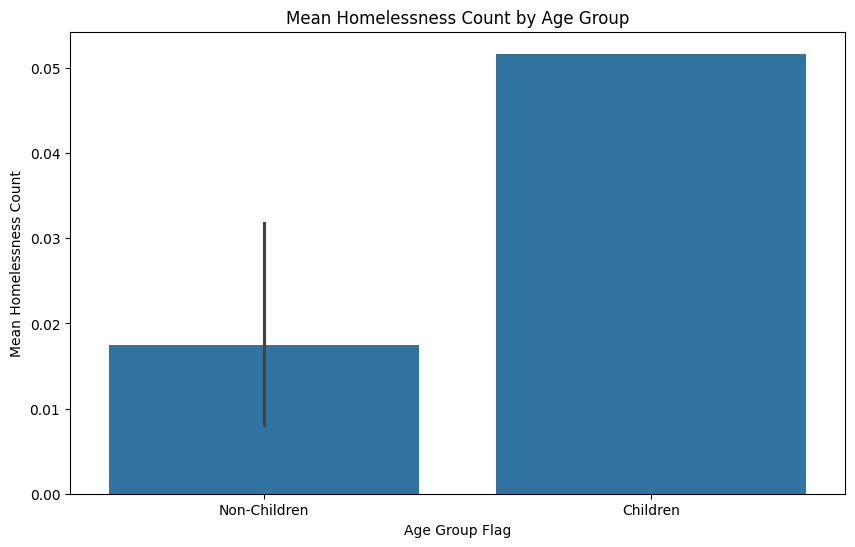

In [23]:
# Calculate mean homelessness counts by demographic flags
mean_counts_by_demo = consolidated_data.groupby(['Children_Flag', 'Adult_Flag', 'Elder_Flag']).agg({
    'EXPERIENCING_HOMELESSNESS_CNT_x': 'mean'
}).reset_index()

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(data=mean_counts_by_demo, x='Children_Flag', y='EXPERIENCING_HOMELESSNESS_CNT_x')
plt.title('Mean Homelessness Count by Age Group')
plt.ylabel('Mean Homelessness Count')
plt.xlabel('Age Group Flag')
plt.xticks([0, 1], ['Non-Children', 'Children'])
plt.show()


Repeat similar analyses for Adult_Flag and Elder_Flag to compare across different demographics. These visualizations can highlight which age groups might be more susceptible to homelessness, informing your logistic regression model.

In [64]:
consolidated_data_simplified = pd.read_csv('./data/normalized/consolidatedNDataSimplified.csv')

In [77]:
print(consolidated_data_simplified.dtypes)

Unnamed: 0                           int64
CALENDAR_YEAR                        int64
AGE_GROUP_PUBLIC                    object
EXPERIENCING_HOMELESSNESS_CNT_x    float64
GENDER                              object
EXPERIENCING_HOMELESSNESS_CNT_y    float64
RACE                                object
RACE ALONE OR IN COMBINATION        object
EXPERIENCING_HOMELESSNESS_CNT       object
Children_Flag                        int64
Adult_Flag                           int64
Elder_Flag                           int64
dtype: object


In [81]:
# Selecting features for clustering
features_to_encode = ['GENDER', 'RACE', 'RACE ALONE OR IN COMBINATION', 'AGE_GROUP_PUBLIC']
numeric_features = ['EXPERIENCING_HOMELESSNESS_CNT_x', 'EXPERIENCING_HOMELESSNESS_CNT_y', 'EXPERIENCING_HOMELESSNESS_CNT', 'Children_Flag', 'Adult_Flag', 'Elder_Flag']

# Replace "<function <lambda> at 0x...>" with NaN, then convert to numeric
for col in numeric_features:
    consolidated_data_simplified[col] = consolidated_data_simplified[col].replace('<function <lambda> at 0x30ddc53a0>', np.nan)
    consolidated_data_simplified[col] = pd.to_numeric(consolidated_data_simplified[col], errors='raise')

consolidated_data_simplified[numeric_features] = consolidated_data_simplified[numeric_features].fillna(0)
for col in numeric_features:
    consolidated_data_simplified[col] = pd.to_numeric(consolidated_data_simplified[col], errors='raise')

consolidated_data_simplified[features_to_encode] = consolidated_data_simplified[features_to_encode].fillna('Unknown')

# Remove 'unknown' AGE_GROUP_PUBLIC
consolidated_data_simplified = consolidated_data_simplified[consolidated_data_simplified['AGE_GROUP_PUBLIC'] != 'Unknown']
consolidated_data_simplified = consolidated_data_simplified[consolidated_data_simplified['GENDER'] != 'Unknown']
# Pipeline for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), features_to_encode)
    ])

# Applying the preprocessing pipeline
X_prepared = preprocessor.fit_transform(consolidated_data_simplified)

In [82]:
# Determine optimal number of clusters, for example, using the elbow method (code for elbow method not shown)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_prepared)

# Add cluster labels to the original DataFrame
consolidated_data_simplified['Cluster'] = clusters


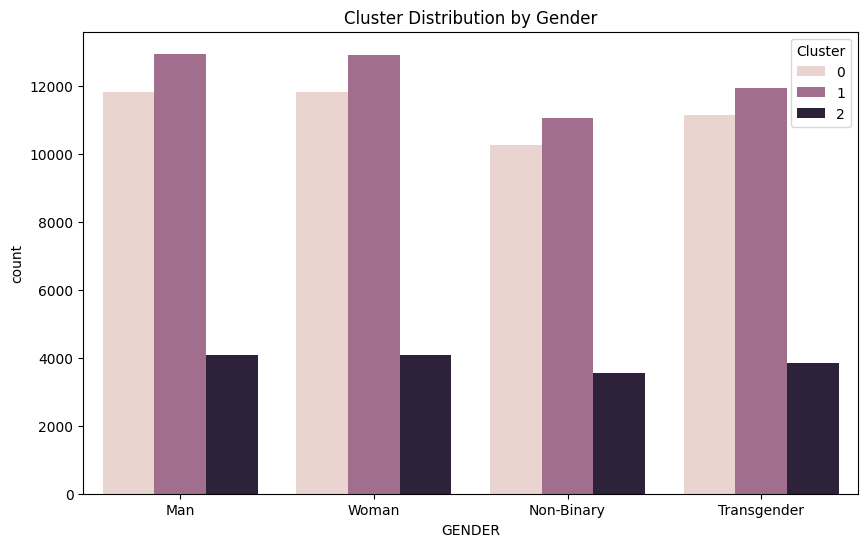

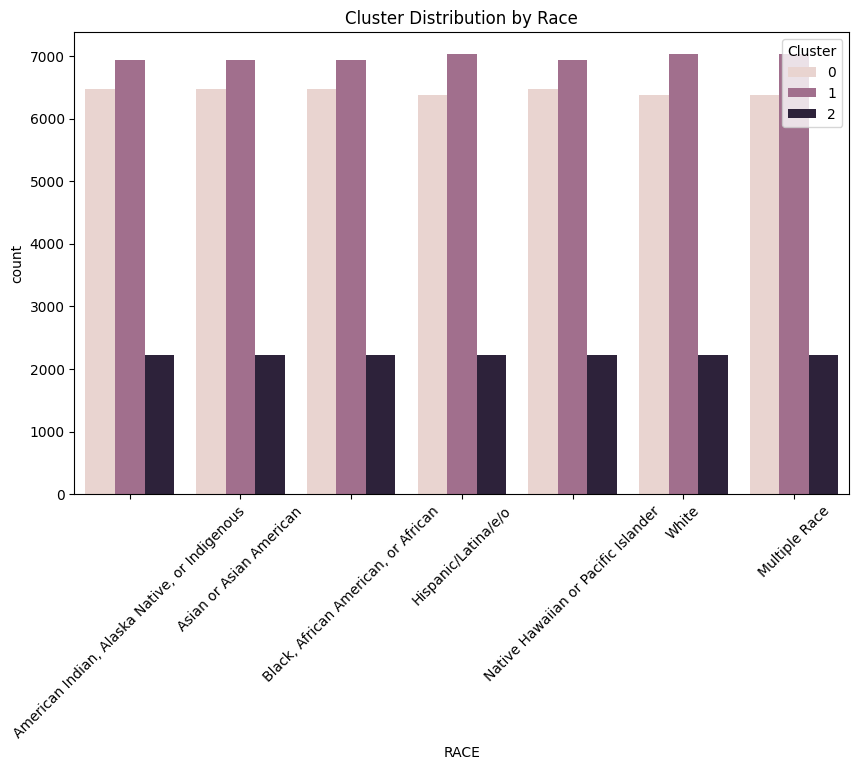

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt

# Cluster distribution across Gender
plt.figure(figsize=(10, 6))
sns.countplot(data=consolidated_data_simplified, x='GENDER', hue='Cluster')
plt.title('Cluster Distribution by Gender')
plt.show()

# Cluster distribution across Race
plt.figure(figsize=(10, 6))
sns.countplot(data=consolidated_data_simplified, x='RACE', hue='Cluster')
plt.title('Cluster Distribution by Race')
plt.xticks(rotation=45)
plt.show()


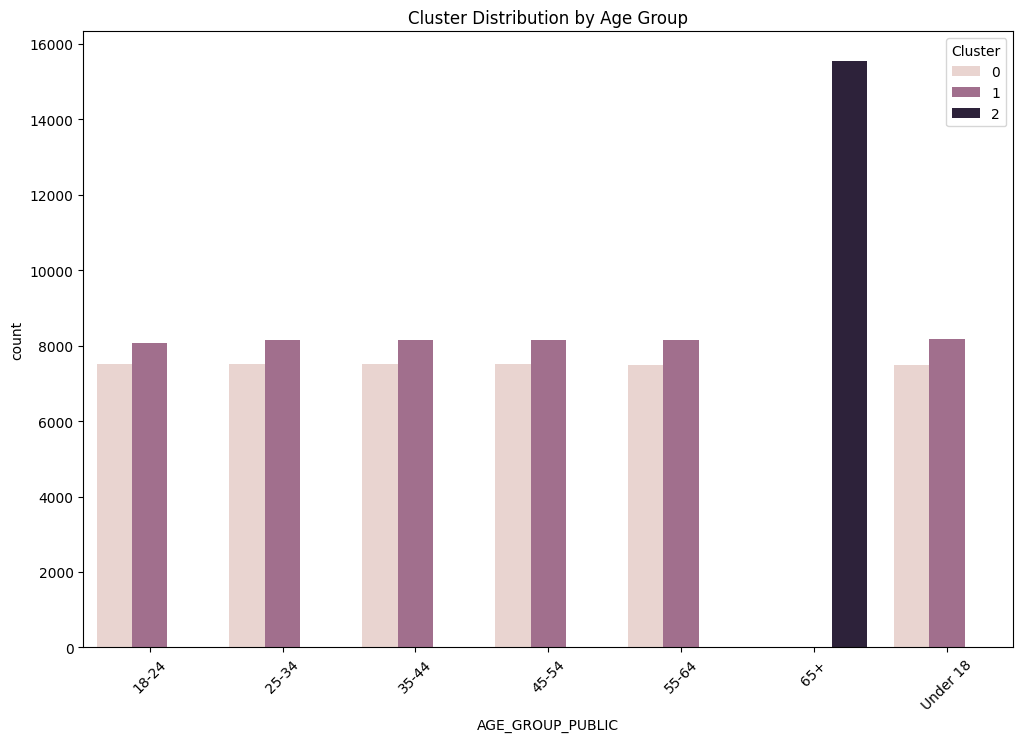

In [84]:
plt.figure(figsize=(12, 8))
sns.countplot(data=consolidated_data_simplified, x='AGE_GROUP_PUBLIC', hue='Cluster')
plt.title('Cluster Distribution by Age Group')
plt.xticks(rotation=45)
plt.show()

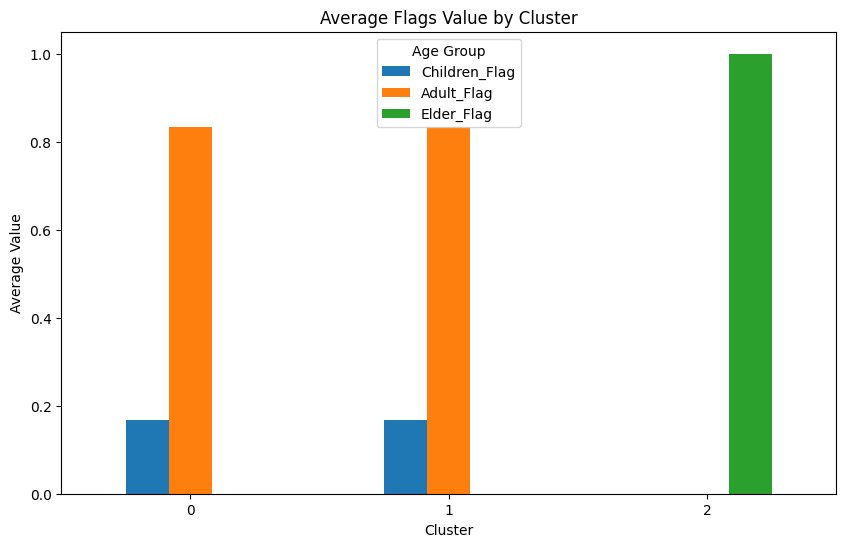

In [86]:
# Correcting the selection of multiple columns to use a list instead of a tuple
cluster_flags_means = consolidated_data_simplified.groupby('Cluster')[['Children_Flag', 'Adult_Flag', 'Elder_Flag']].mean()

# Now, plotting the means
import matplotlib.pyplot as plt

cluster_flags_means.plot(kind='bar', figsize=(10, 6))
plt.title('Average Flags Value by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Value')
plt.xticks(rotation=0)
plt.legend(title='Age Group')
plt.show()


In [87]:
# Calculating the correlation matrix
numeric_features = [
    'EXPERIENCING_HOMELESSNESS_CNT_x', 
    'EXPERIENCING_HOMELESSNESS_CNT_y', 
    'EXPERIENCING_HOMELESSNESS_CNT',
    'Children_Flag', 
    'Adult_Flag', 
    'Elder_Flag',
    'Cluster'  # Including the cluster labels as well, to see how they correlate with other features
]


In [89]:
from sklearn.preprocessing import OneHotEncoder

# Initialize the OneHotEncoder
encoder = OneHotEncoder()

# Fit and transform 'GENDER' and 'RACE' columns and convert to dense array
encoded_columns = encoder.fit_transform(consolidated_data_simplified[['GENDER', 'RACE']]).toarray()

# Alternatively, if your scikit-learn version supports sparse_output in fit_transform (check documentation for your version)
# encoded_columns = encoder.fit_transform(consolidated_data_simplified[['GENDER', 'RACE']], sparse_output=False)

# Creating a DataFrame with encoded columns, specifying column names
encoded_df = pd.DataFrame(encoded_columns, columns=encoder.get_feature_names_out(['GENDER', 'RACE']))

# Reset the index of your original DataFrame to ensure it aligns for concatenation
consolidated_data_simplified.reset_index(drop=True, inplace=True)

# Concatenate the original DataFrame with the new encoded DataFrame
consolidated_data_simplified_encoded = pd.concat([consolidated_data_simplified, encoded_df], axis=1)

In [90]:
# Assuming 'numeric_features' list is already defined and includes your original numeric features
all_features = numeric_features + list(encoded_df.columns)

# Calculate the correlation matrix
correlation_matrix_encoded = consolidated_data_simplified_encoded[all_features].corr()

# Display the correlation matrix
print(correlation_matrix_encoded)

                                                    EXPERIENCING_HOMELESSNESS_CNT_x  \
EXPERIENCING_HOMELESSNESS_CNT_x                                        1.000000e+00   
EXPERIENCING_HOMELESSNESS_CNT_y                                        6.381468e-01   
EXPERIENCING_HOMELESSNESS_CNT                                          6.368385e-01   
Children_Flag                                                          7.402529e-02   
Adult_Flag                                                            -2.570531e-03   
Elder_Flag                                                            -7.092293e-02   
Cluster                                                                5.641589e-02   
GENDER_Man                                                            -7.740866e-03   
GENDER_Non-Binary                                                      1.331247e-02   
GENDER_Transgender                                                     2.820400e-03   
GENDER_Woman                               

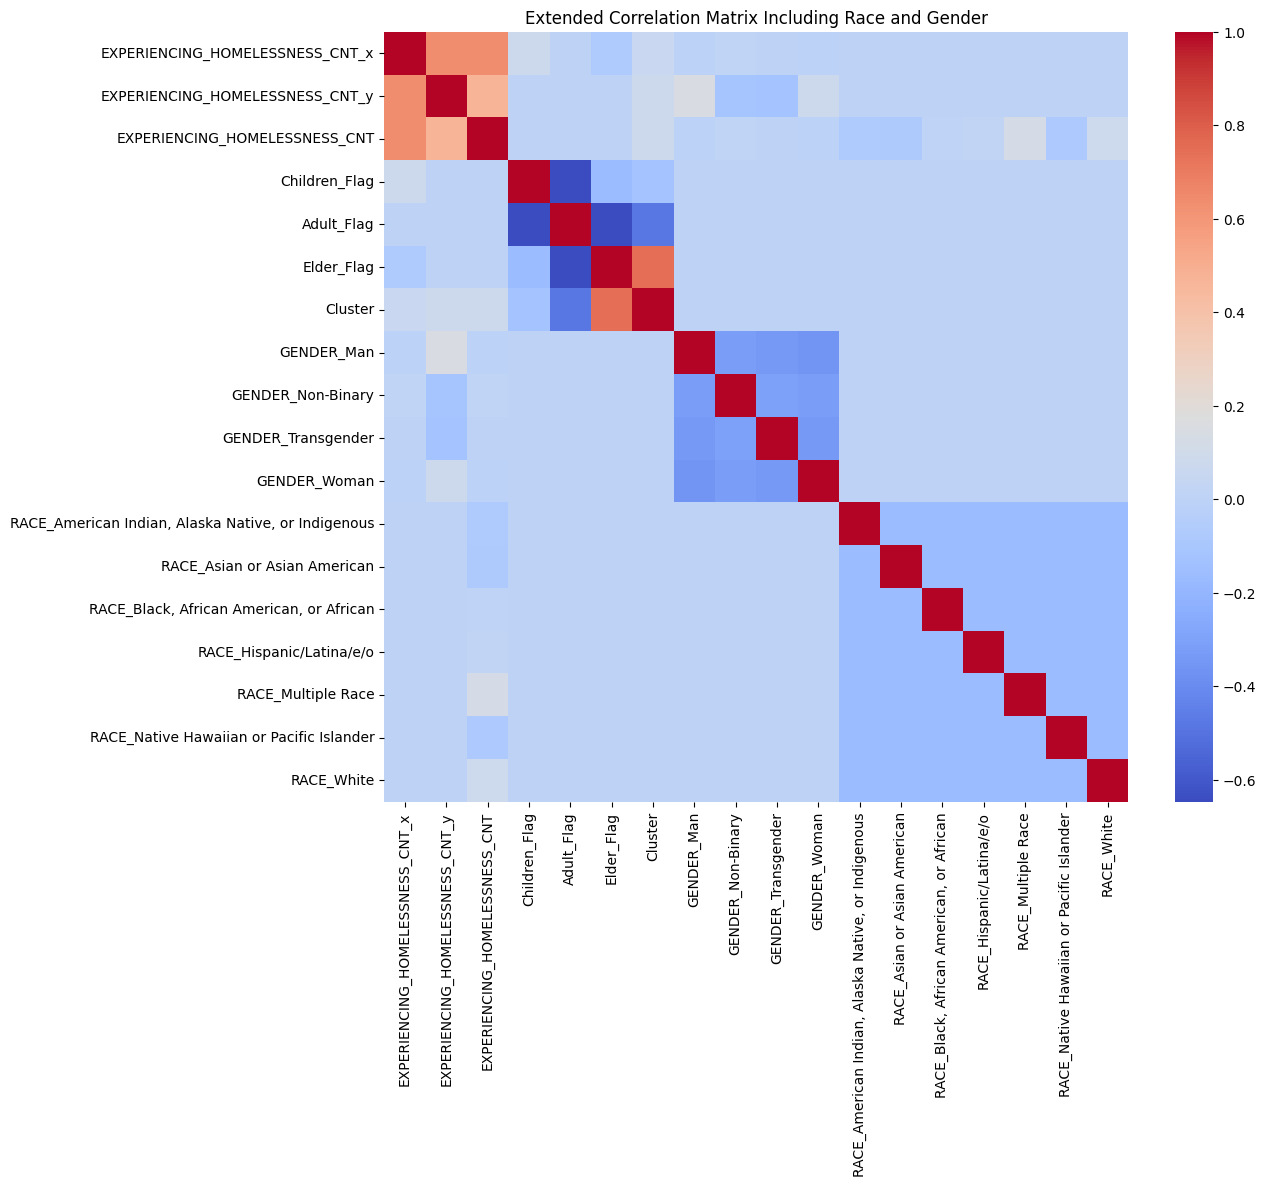

In [94]:
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_encoded, annot=False, cmap='coolwarm')
plt.title('Extended Correlation Matrix Including Race and Gender')
plt.show()

In [99]:
import scipy.stats as stats
# Assuming 'numeric_features' list is already defined and includes your original numeric features
all_features = numeric_features + list(encoded_df.columns)

# Calculate the correlation matrix
correlation_matrix_encoded = consolidated_data_simplified_encoded[all_features].corr()

# Create an empty DataFrame to store significant correlations
significant_correlations = pd.DataFrame(index=correlation_matrix_encoded.index, columns=correlation_matrix_encoded.columns)

# Iterate over each pair of variables in the correlation matrix
for i in range(len(correlation_matrix_encoded.columns)):
    for j in range(i+1, len(correlation_matrix_encoded.columns)):
        var1 = correlation_matrix_encoded.columns[i]
        var2 = correlation_matrix_encoded.columns[j]
        corr_coefficient, p_value = stats.pearsonr(consolidated_data_simplified_encoded[var1], consolidated_data_simplified_encoded[var2])
        
        # Check if the p-value is less than the significance level (e.g., 0.05)
        if p_value < 0.05:
            significant_correlations.loc[var1, var2] = corr_coefficient

# Filter out NaN values (non-significant correlations)
significant_correlations = significant_correlations.dropna(axis=0, how='all').dropna(axis=1, how='all')

# Display the significant correlation 
print(significant_correlations)

                                                   EXPERIENCING_HOMELESSNESS_CNT_y  \
EXPERIENCING_HOMELESSNESS_CNT_x                                           0.638147   
EXPERIENCING_HOMELESSNESS_CNT_y                                                NaN   
EXPERIENCING_HOMELESSNESS_CNT                                                  NaN   
Children_Flag                                                                  NaN   
Adult_Flag                                                                     NaN   
Elder_Flag                                                                     NaN   
GENDER_Man                                                                     NaN   
GENDER_Non-Binary                                                              NaN   
GENDER_Transgender                                                             NaN   
RACE_American Indian, Alaska Native, or Indigenous                             NaN   
RACE_Asian or Asian American                          

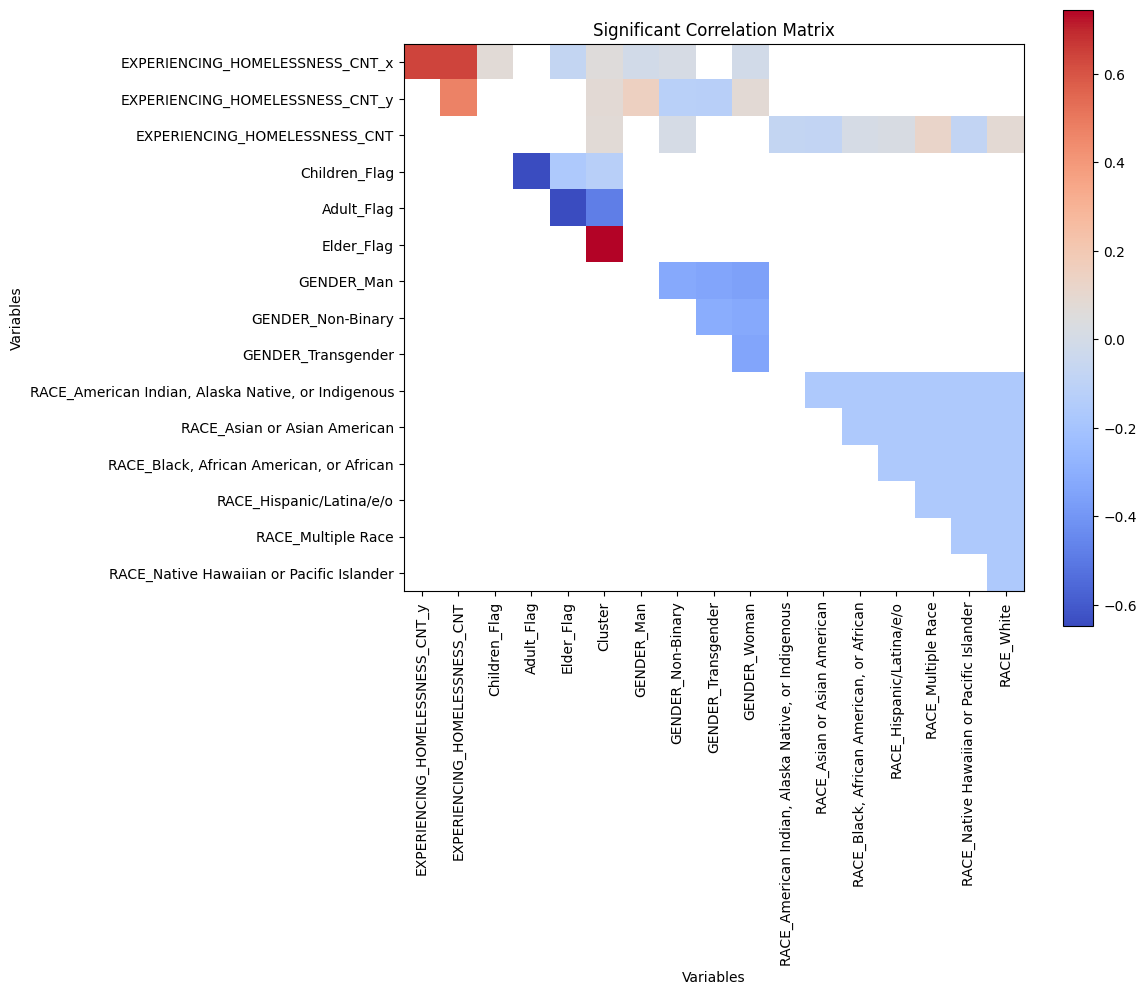

In [101]:
# Convert data type to float
significant_correlations = significant_correlations.astype(float)

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
plt.imshow(significant_correlations, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.title('Significant Correlation Matrix')
plt.xlabel('Variables')
plt.ylabel('Variables')
plt.xticks(ticks=range(len(significant_correlations.columns)), labels=significant_correlations.columns, rotation=90)
plt.yticks(ticks=range(len(significant_correlations.index)), labels=significant_correlations.index)
plt.show()
